# Algotrading - Aula 3 - Parte I

Analisando Market Data em diferentes níveis
___

Vamos começar importando algumas bibliotecas úteis

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from scipy import stats

from IPython import display

Instalar também uma biblioteca também útil para pegar dados de fechamento direito do yahoo finance:

In [4]:
!pip install yahoofinancials

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.14-py3-none-any.whl size=28645 sha256=b89842371b284ac388858f8165a48e5f6431417fedb409ab406a479bb10cbe08
  Stored in directory: /home/antonio/.cache/pip/wheels/32/a3/b6/b5b33187f2d42f095fecc236b957b46173fa09e78a106e309f
Successfully built yahoofinancials


Agora vamos baixar dados de fechamento (**Historical Data**) de 6 meses diretamente do site

In [5]:
import yahoofinancials as yf
ticker = '^BVSP'

start_date = '2020-09-08'
end_date =  '2021-03-08'

data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')

Vamos dar uma olhadinha nos dados

In [6]:
print(data)

{'^BVSP': {'eventsData': {}, 'firstTradeDate': {'formatted_date': '1993-04-27', 'date': 735915600}, 'currency': 'BRL', 'instrumentType': 'INDEX', 'timeZone': {'gmtOffset': -10800}, 'prices': [{'date': 1599570000, 'high': 101239.0, 'low': 99373.0, 'open': 101239.0, 'close': 100050.0, 'volume': 8479000, 'adjclose': 100050.0, 'formatted_date': '2020-09-08'}, {'date': 1599656400, 'high': 101578.0, 'low': 100050.0, 'open': 100050.0, 'close': 101292.0, 'volume': 7955600, 'adjclose': 101292.0, 'formatted_date': '2020-09-09'}, {'date': 1599742800, 'high': 101536.0, 'low': 98687.0, 'open': 101291.0, 'close': 98835.0, 'volume': 8894600, 'adjclose': 98835.0, 'formatted_date': '2020-09-10'}, {'date': 1599829200, 'high': 99435.0, 'low': 97758.0, 'open': 98839.0, 'close': 98363.0, 'volume': 9107900, 'adjclose': 98363.0, 'formatted_date': '2020-09-11'}, {'date': 1600088400, 'high': 100520.0, 'low': 98367.0, 'open': 98367.0, 'close': 100275.0, 'volume': 8182100, 'adjclose': 100275.0, 'formatted_date':

Parece complicado de ler. Os dados estão em um formato JSON e felizmente temos uma função que imprime de um modo melhor para a visualização

In [7]:
from pprint import pprint
pprint(data)

{'^BVSP': {'currency': 'BRL',
           'eventsData': {},
           'firstTradeDate': {'date': 735915600,
                              'formatted_date': '1993-04-27'},
           'instrumentType': 'INDEX',
           'prices': [{'adjclose': 100050.0,
                       'close': 100050.0,
                       'date': 1599570000,
                       'formatted_date': '2020-09-08',
                       'high': 101239.0,
                       'low': 99373.0,
                       'open': 101239.0,
                       'volume': 8479000},
                      {'adjclose': 101292.0,
                       'close': 101292.0,
                       'date': 1599656400,
                       'formatted_date': '2020-09-09',
                       'high': 101578.0,
                       'low': 100050.0,
                       'open': 100050.0,
                       'volume': 7955600},
                      {'adjclose': 98835.0,
                       'close': 98835.0,
       

Agora que sabemos como separar o que interessa, vamos começar a montar nosso dataframe

In [8]:
# Ler os dados do JSON
ibov_raw = pd.DataFrame(data[ticker]['prices']).dropna()
# Converter a data para o tipo correto datetime
ibov_raw['formatted_date'] = pd.to_datetime(ibov_raw['formatted_date'])
# Indica a data como o índice de cada linha
ibov_raw = ibov_raw.set_index('formatted_date')
# Visualiza o resultado
ibov_raw.head()

,date,high,low,open,close,volume,adjclose
formatted_date,,,,,,,
2020-09-08,1599570000,101239.0,99373.0,101239.0,100050.0,8479000,100050.0
2020-09-09,1599656400,101578.0,100050.0,100050.0,101292.0,7955600,101292.0
2020-09-10,1599742800,101536.0,98687.0,101291.0,98835.0,8894600,98835.0
2020-09-11,1599829200,99435.0,97758.0,98839.0,98363.0,9107900,98363.0
2020-09-14,1600088400,100520.0,98367.0,98367.0,100275.0,8182100,100275.0


Vamos remover as colunas que não interessam muito, mantendo o padrão OHLC (Open, High, Low, Close) para de fechamento, mais o volume

In [9]:
ibov = ibov_raw.iloc[:,1:-1]
ibov.head()

,high,low,open,close,volume
formatted_date,,,,,
2020-09-08,101239.0,99373.0,101239.0,100050.0,8479000
2020-09-09,101578.0,100050.0,100050.0,101292.0,7955600
2020-09-10,101536.0,98687.0,101291.0,98835.0,8894600
2020-09-11,99435.0,97758.0,98839.0,98363.0,9107900
2020-09-14,100520.0,98367.0,98367.0,100275.0,8182100


Começando a explorar os dados

In [10]:
# Medidas Resumo
ibov.close.describe()

count       119.000000
mean     109164.689076
std        9417.099315
min       93580.000000
25%       99863.000000
50%      111184.000000
75%      118195.500000
max      125077.000000
Name: close, dtype: float64

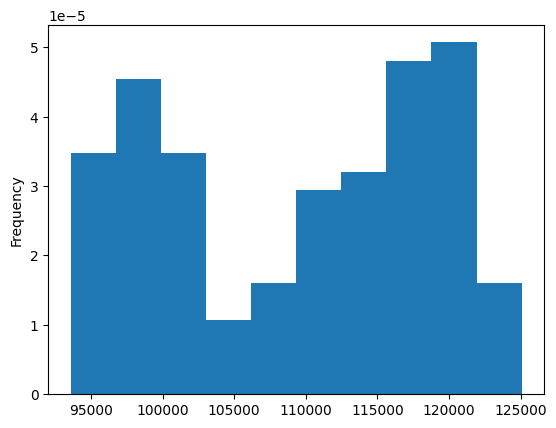

In [11]:
# Histograma (de preços)
ibov.close.plot.hist(density=True);

Pergunta: Faz sentido esse histograma?
___
Para montar o gráfico de candlestick, vamos instalar mais uma biblioteca:

In [12]:
!pip install mplfinance

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 KB 1.8 MB/s eta 0:00:000:00:01


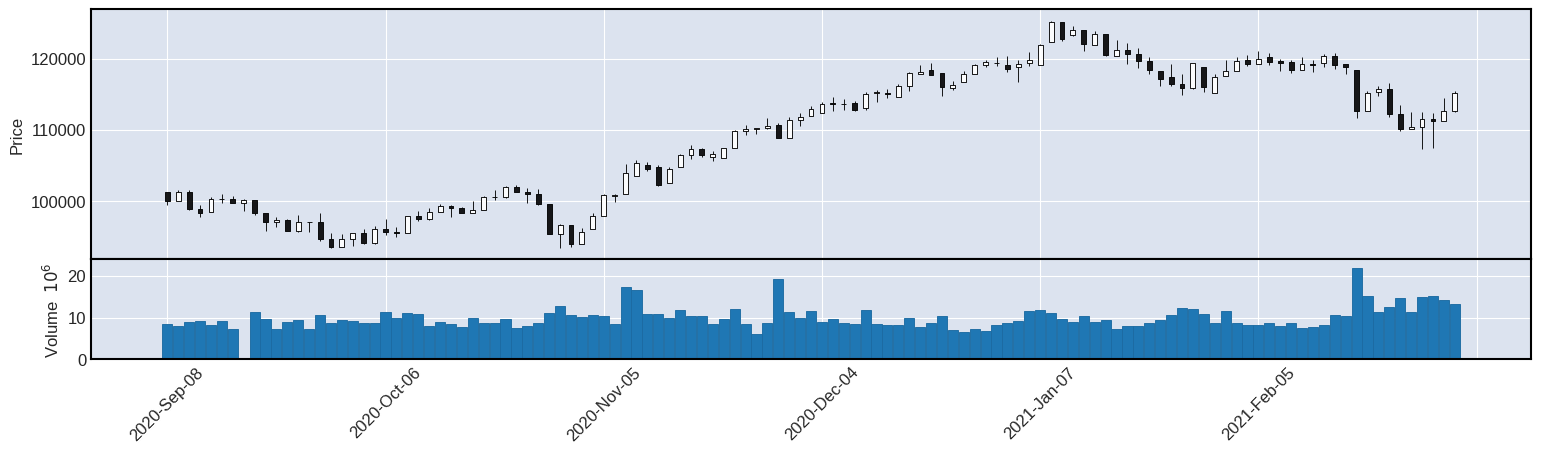

In [13]:
import mplfinance as mpf
mpf.plot(ibov,type='candle', volume=True, figsize=(20,5))

___
Conforme comentado na aula passa, de onde vem esses preços? 
Toda história de um dia pode ser contada em 4 pontos (OHLC)?

Vamos analisar o **RAW DATA** do arquivo de negociações (trades)

In [14]:
brkm5 = pd.read_csv('NEG_BRKM5.csv')
brkm5.head(25)

,Data Sessao,Ativo,Nr.Negocio,Preco,Quantidade,Hora,Anulacao,Data CPA,Num CPA,Data VDA,Num VDA,Comprador,Vendedor
0,2019-09-13,BRKM5,10,30.09,100,10:05:00.000,1,2019-09-13,84793902007,84793916889,84793916889,45,147
1,2019-09-13,BRKM5,20,30.09,100,10:05:00.000,1,2019-09-13,84793918583,84793917059,84793917059,308,147
2,2019-09-13,BRKM5,100,30.09,100,10:05:00.000,1,2019-09-13,84793903323,84793895663,84793895663,308,3
3,2019-09-13,BRKM5,90,30.09,100,10:05:00.000,1,2019-09-13,84793902822,84793908650,84793908650,308,308
4,2019-09-13,BRKM5,80,30.09,100,10:05:00.000,1,2019-09-13,84793895660,84793908650,84793908650,3,308
5,2019-09-13,BRKM5,70,30.09,500,10:05:00.000,1,2019-09-13,84793921104,84793908650,84793908650,3,308
6,2019-09-13,BRKM5,30,30.09,200,10:05:00.000,1,2019-09-13,84793917259,84793919867,84793919867,3,85
7,2019-09-13,BRKM5,40,30.09,100,10:05:00.000,1,2019-09-13,84793917259,84793923595,84793923595,3,147
8,2019-09-13,BRKM5,50,30.09,200,10:05:00.000,1,2019-09-13,84793917259,84793908650,84793908650,3,308
9,2019-09-13,BRKM5,60,30.09,100,10:05:00.000,1,2019-09-13,84793903252,84793908650,84793908650,40,308


Legenda das colunas:

```
Data Sessão      Data de sessão
Ativo            Símbolo do Instrumento
Nr.Negócio       Número do negócio
Preco            Preço do negócio
Quantidade       Quantidade negociada
Hora             Horário da negociação (formato HH:MM:SS.NNN)
Anulacao         Indicador de Anulação: "1" - ativo / "2" - cancelado
Data CPA         Data da oferta de compra
Num CPA          Número sequencial da oferta de compra
Data VDA         Data da oferta de venda
Num VDA          Número sequencial da oferta de venda
Comprador        Código de identificação da corretora de compra
Vendedor         Código de identificação da corretora de venda
```

Ou seja, cada linha do DataFrame representa uma operação que ocorreu em um determinado dia.

Como é montado o candle desse dia?

In [15]:
print('Open: {}'.format(brkm5.iloc[0,:]['Preco'])) # Primeiro
print('High: {}'.format(max(brkm5['Preco']))) # Máximo
print('Low: {}'.format(min(brkm5['Preco']))) # Mínimo
print('Close: {}'.format(brkm5.iloc[-1,:]['Preco'])) # Último

Open: 30.09
High: 30.28
Low: 29.52
Close: 29.76


Quantas operações aconteceram nesse dia?

In [16]:
len(brkm5)

7296

Vamos dar uma olhadinha no gráfico de preços

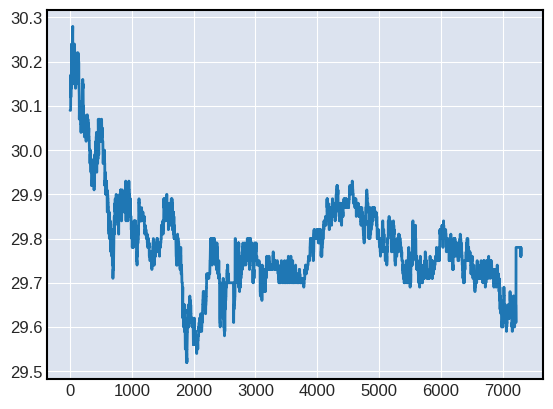

In [17]:
brkm5['Preco'].plot();

Faz sentido esse gráfico? O que representa o eixo x?
___

Vamos dar uma olhada em algumas informações que não tínhamos nos dados do yahoo finance:

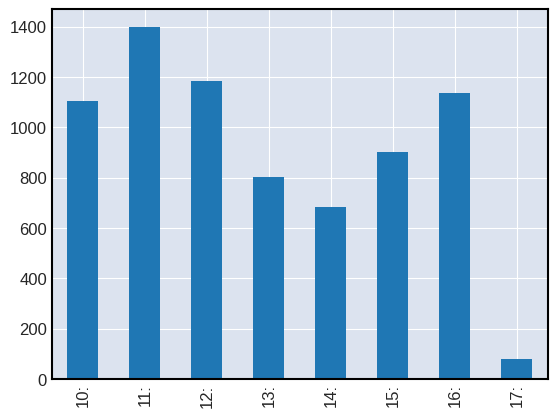

In [18]:
# Número de negócios por hora do dia:

brkm5['Hora'].str[:3].value_counts().sort_index().plot(kind='bar');

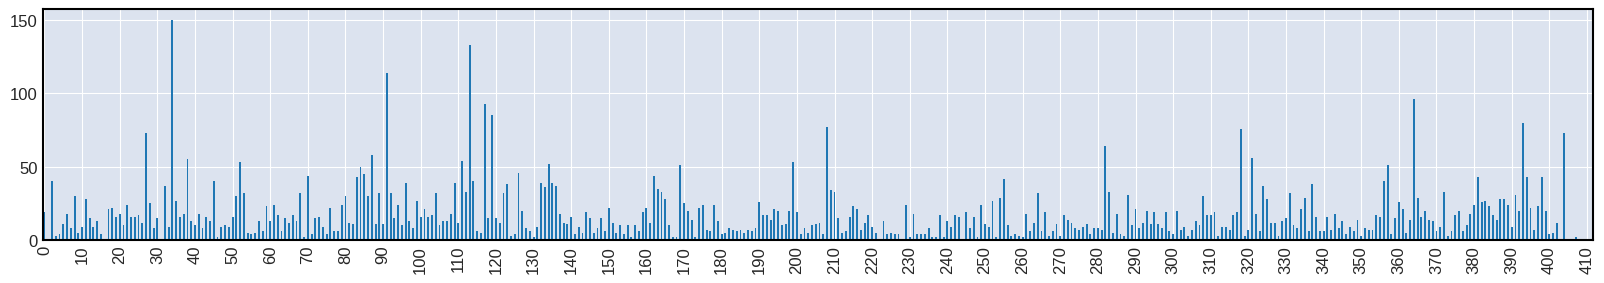

In [19]:
# Número de negócios minuto a minuto

minutes = brkm5['Hora'].str[:5].value_counts().sort_index()
minutes.plot(kind='bar', figsize=(20,3), xticks=range(0, len(minutes),10));

In [20]:
# Quantos negócios no primeiro minuto do dia?

min1 = brkm5[brkm5['Hora'].str.contains('10:05:')]
len(min1)

19

In [21]:
# Candle do primeiro minuto do dia

print('Open: {}'.format(min1.iloc[0,:]['Preco']))
print('High: {}'.format(max(min1['Preco'])))
print('Low: {}'.format(min(min1['Preco'])))
print('Close: {}'.format(min1.iloc[-1,:]['Preco']))

Open: 30.09
High: 30.17
Low: 30.09
Close: 30.14


Lembrando que o candle não dá noção de ordem dos acontecimentos, vendo ponto a ponto:

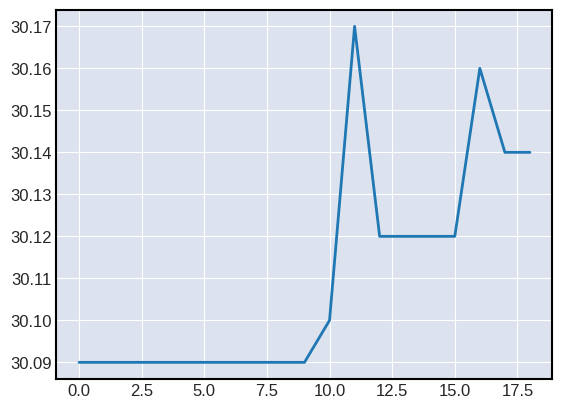

In [22]:
min1['Preco'].plot();

Vamos separar apenas os últimos trades de cada minuto

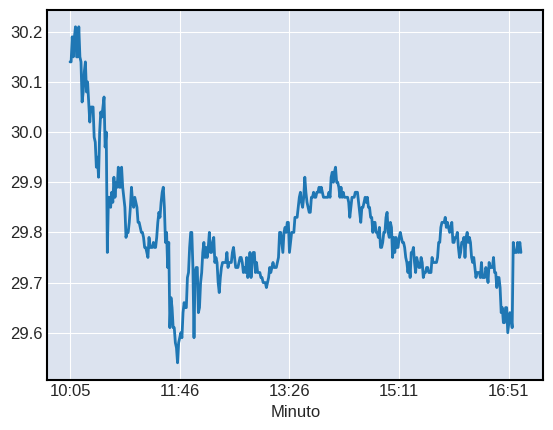

In [23]:
brkm5['Minuto'] = brkm5['Hora'].str[:5]
brkm5.groupby(by='Minuto').last()['Preco'].plot();

Agora uma comparação do gráfico tick-by-tick com o close de cada minuto

In [24]:
len(brkm5.groupby(by='Minuto').last()['Preco'])

412

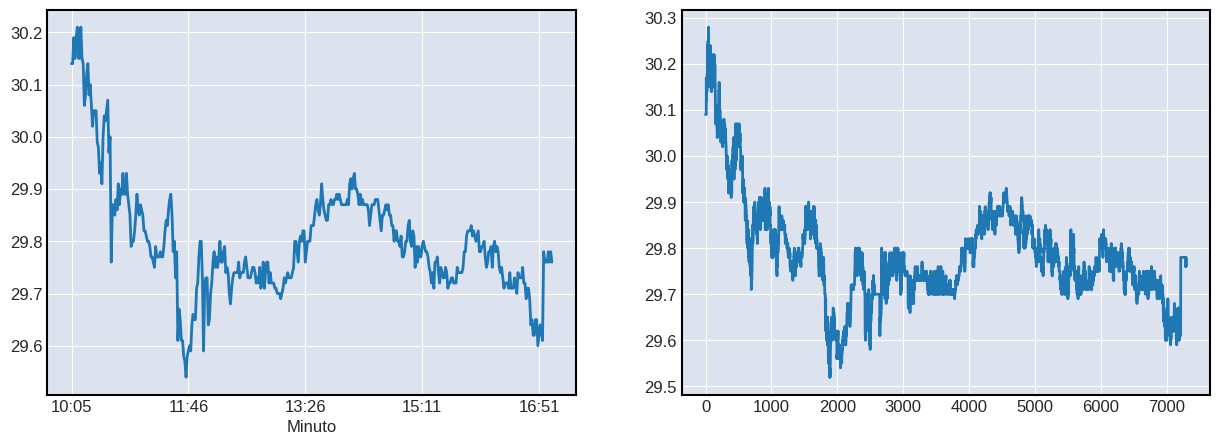

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
brkm5.groupby(by='Minuto').last()['Preco'].plot();
plt.subplot(1,2,2)
brkm5['Preco'].plot();

Você consegue notar alguma diferença?

In [26]:
print(len(brkm5.groupby(by='Minuto').last()['Preco']))
print(len(brkm5['Preco']))

412
7296


Selecionando apenas os primeiros 50 pontos

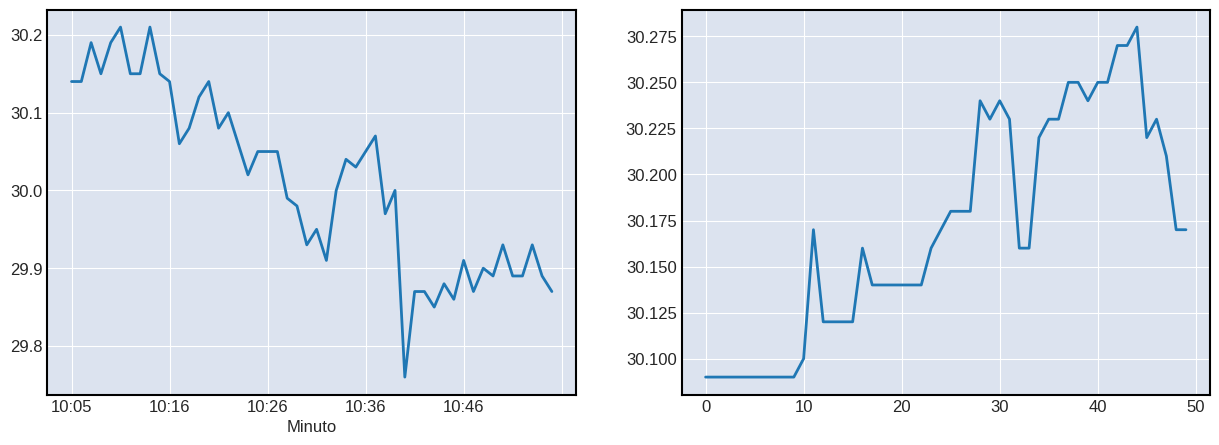

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
brkm5.groupby(by='Minuto').last().iloc[:50,:]['Preco'].plot();
plt.subplot(1,2,2)
brkm5.iloc[:50,:]['Preco'].plot();

Conclusão: apesar de parecidos, os gráficos não são comparáveis, pois os eixos significam unidades distintas e o tick-by-tick possuim muito mais pontos.
___

E o **Intraday Data**? Basta escolher uma discretização (normalmente em minutos) e agrupar os preços

In [28]:
# Montando o candle
minuto = brkm5.groupby(by='Minuto')

#intra.index = pd.to_datetime(intra.index)

intra = pd.DataFrame({'date': pd.to_datetime(minuto.first().index), 
                      'open': minuto.first()['Preco'], 
                      'high': minuto.max()['Preco'],
                      'low': minuto.min()['Preco'], 
                      'close': minuto.last()['Preco'] })

intra = intra.set_index('date')

intra.head()

,open,high,low,close
date,,,,
2023-02-28 10:05:00,30.09,30.17,30.09,30.14
2023-02-28 10:06:00,30.14,30.14,30.14,30.14
2023-02-28 10:07:00,30.14,30.28,30.14,30.19
2023-02-28 10:08:00,30.15,30.15,30.15,30.15
2023-02-28 10:10:00,30.16,30.19,30.16,30.19


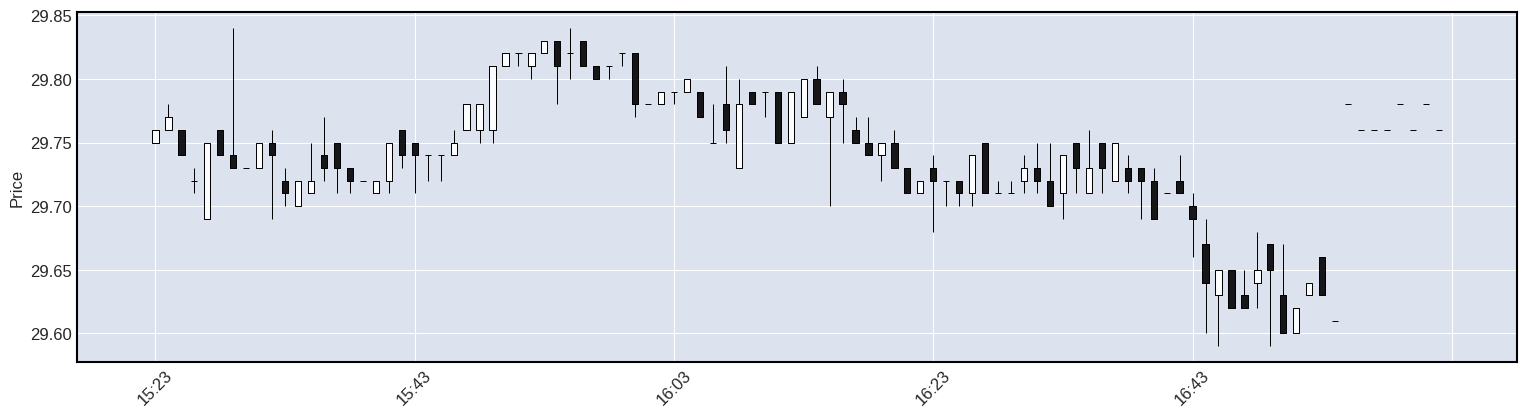

In [29]:
mpf.plot(intra.iloc[-100:],type='candle', figsize=(20,5))

E os dados de BID/ASK?

Estão em outros arquivos:

In [30]:
brkm5_cpa = pd.read_csv('OFER_CPA_BRKM5.csv')
brkm5_cpa.head(25)

,Data Sessao,Ativo,Sentido,Num CPA,GenerationID CPA,Evento,Hora Prioridade,Ind de Prioridade,Preco,Qtd.Total,Qtd.Negociada,Data Oferta,Data de Entrada,Estado,Condicao,Corretora
0,2019-09-13,BRKM5,1,84534855732,14764482,1,09:45:17.012000,2147483647,45.90,100,0,2019-04-10,2019-04-10 09:45:17,0,0,3
1,2019-09-13,BRKM5,1,84534855733,14764483,1,09:45:17.023000,2147483647,46.77,100,0,2019-04-10,2019-04-10 09:45:17,0,0,3
2,2019-09-13,BRKM5,1,84534960446,15073161,1,10:26:20.679000,2147483647,46.05,100,0,2019-04-10,2019-04-10 10:26:20,0,0,114
3,2019-09-13,BRKM5,1,84535773323,18030371,1,12:40:20.181000,2147483647,47.50,200,0,2019-04-10,2019-04-10 12:40:20,0,0,72
4,2019-09-13,BRKM5,1,84544071552,9479628,1,11:10:15.483000,2147483647,46.95,100,0,2019-04-16,2019-04-16 11:10:15,0,0,3
5,2019-09-13,BRKM5,1,84583291318,3515804,2,11:54:31.586000,2147483647,23.75,100,0,2019-08-26,2019-08-26 11:54:31,5,0,27
6,2019-09-13,BRKM5,1,84583291318,3543967,2,11:55:37.864000,2147483647,23.23,100,0,2019-08-26,2019-08-26 11:55:37,5,0,27
7,2019-09-13,BRKM5,1,84583291318,4864129,2,13:11:29.119000,2147483647,23.75,100,0,2019-08-12,2019-08-12 13:11:29,5,0,27
8,2019-09-13,BRKM5,1,84583291318,10200859,2,10:23:38.115000,2147483647,28.89,100,0,2019-06-04,2019-06-04 10:23:38,5,0,27
9,2019-09-13,BRKM5,1,84583291318,10215914,2,10:24:20.036000,2147483647,28.88,100,0,2019-06-04,2019-06-04 10:24:20,5,0,27


In [31]:
brkm5_vda = pd.read_csv('OFER_VDA_BRKM5.csv')
brkm5_vda.head()

,Data Sessao,Ativo,Sentido,Num VDA,GenerationID VDA,Evento,Hora Prioridade,Ind de Prioridade,Preco,Qtd.Total,Qtd.Negociada,Data Oferta,Data de Entrada,Estado,Condicao,Corretora
0,2019-09-13,BRKM5,2,84496155021,9361896,2,10:49:53.488000,2147483647,40.0,3000,0,2019-07-16,2019-07-16 10:49:53,5,0,3
1,2019-09-13,BRKM5,2,84496155021,12026287,2,15:14:56.133000,2147483647,45.0,3000,0,2019-06-25,2019-06-25 15:14:56,5,0,3
2,2019-09-13,BRKM5,2,84496155021,19591674,2,17:30:01.496000,2147483647,34.0,1000,0,2019-08-06,2019-08-06 17:30:01,5,0,3
3,2019-09-13,BRKM5,2,84499567268,31398288,2,09:45:25.486000,2147483647,48.0,400,0,2019-08-22,2019-08-22 09:45:25,5,0,3
4,2019-09-13,BRKM5,2,84528551583,9235057,2,17:36:48.708000,2147483647,49.5,200,0,2019-08-12,2019-08-12 17:36:48,5,0,3


In [32]:
print(len(brkm5_cpa))
print(len(brkm5_vda))

36406
39875


E tem muita coisa para explorar nesses dados como por exemplo:

1. Proporção de ordens que foram executadas?
2. Qual é a ordem de compra mais longe (baixa) do preço?
3. Qual é o formato da fila ao longo do dia?
4. Em qual lado teve mais agressões na fila?
5. Existiu alguma ordem de tamanho desproporcional?
6. O que são *Heikin Ashi Chart* e *Renko Chart*?

Notem que é possível contar a história do dia todo com os 3 arquivos (NEG, CPA e VDA)

Ainda, a quantidade de dados gerados diariamente é enorme. Nesse exemplo pegamos uma ação não muito negociada e os dados de apenas 1 dia.